# Reentry Chile Response Rate

*Sebastian Daza*

In this report I describe response rates by wave. I follow these general criteria:

- The estimation by wave only uses cases far beyond the wave-specific observation window. For instance, for the wave 2-months, we only consider those women who have been in the study for 4 months.
- This estimation is based on the administrative records of the study.

Some important definitions:

- Names of waves: baseline, week, two_months six_months
- Variables names: `d` means date, `c` means clean, and `cd` clean date
- Deadline corresponds to th time threshold to compute a given response rate

I review the key date variables to compute the rates and highlight inconsistencies or problems. 

## Release

There are two date of release variables
in the register data. *Definitive* has a bunch of missing records. **We should define a validaded and unique date of release variable*. 

In [344]:
import pandas as pd
path = '/Users/sdaza/Google Drive/github/reentry-chile/reports/data/20170628 Logros.xlsx'
file = pd.ExcelFile(path)

df = file.parse(-1)
df.columns = map(str.lower, df.columns)

In [345]:
# rename some variables
old_names = ['id folio', 'encuestadora final', 'fecha egreso', 'fecha egreso definitiva']
new_names = ['id', 'interviewer', 'release_o', 'release']
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
cnames = list(df.columns)

In [346]:
s = df.release.isnull()
df.loc[s, 'release'] = df.loc[s, 'release_o']

In [347]:
start = pd.to_datetime("09/01/2016")

s = (df.release < start) & (df.release_o >= start)
df.loc[s, ['release']] = df.loc[s, ['release_o']]

df['release_year'] = pd.DatetimeIndex(df['release']).year
df['release_month'] = pd.DatetimeIndex(df['release']).month
#print(df.release_year.value_counts())
#print(df.release_month.value_counts())

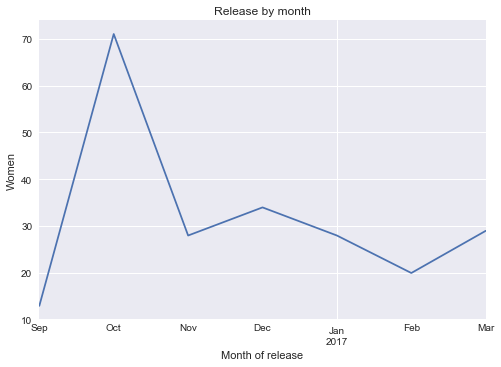

In [348]:
# release plot
import matplotlib.pyplot as plt
plt.style.use("seaborn")

t = df.reset_index().set_index('release')
t = t.resample('M')
ax = t.id.count().plot(title='Release by month')
ax.set_ylabel("Women")
ax.set_xlabel("Month of release")
plt.show()

## Baseline

Let's explore the baseline information. 

Below a plot with the distribution of the difference between the date of the baseline and release. All values should be negative. 

To check cases below where we have issues: missing data or positive value (i.e., the baseline was applied after release). 

In [349]:
# baseline response
varname = [col for col in df.columns if 'sí: se realizó línea base' in col]
#print(varname)

df = df.rename(columns={varname[0]: 'r_baseline'})
#df.r_baseline.value_counts()
df['r_baseline'] = df['r_baseline'].str.contains("s|S").astype(int)
#df.r_baseline.value_counts()  # only ones

In [350]:
# date of baseline
varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)
df = df.rename(columns={varname[0]: 'dbaseline'})

In [351]:
# function to clean dates
import re

def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True, errors = 'coerce')

In [352]:
df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

Some format issues! Look dataframe below.

In [353]:
m = df['cdbaseline'].isnull() & df['dbaseline'].notnull()
df.loc[m, ['id', 'cdbaseline', 'dbaseline']]

,id,cdbaseline,dbaseline
43,40122,NaT,V14 y M18/10
224,40199,NaT,V16/12716


In [354]:
# replace errors in data entry
errors = ['V16/12716', 'V14 y M18/10']
new_values = ['12/16/16', '10/18/16']

for i in range(0,len(errors)):
   df.loc[df['dbaseline'] == errors[i], 'cdbaseline'] = pd.to_datetime(new_values[i])

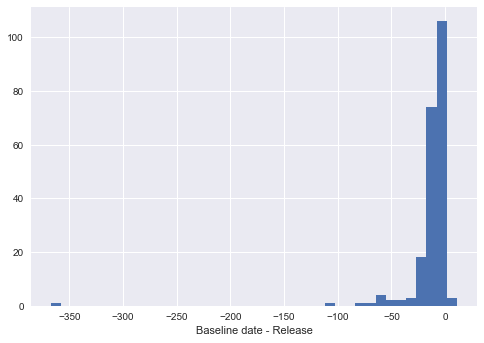

In [355]:
# identify inconsistent cases
df = df.assign(release_baseline = (df.cdbaseline - df.release).dt.days)
# df.release_baseline.describe()
ax = df.release_baseline.hist(bins = 40)
ax.set_xlabel('Baseline date - Release')
plt.show()

In [356]:
s = ((df.release_baseline > 0) | (df.cdbaseline.isnull()))

In [357]:
df.loc[s, ['id', 'r_baseline', 'release',  'cdbaseline', 'dbaseline', 'release_baseline']].sort_values('id')

,id,r_baseline,release,cdbaseline,dbaseline,release_baseline
138,10272,1,2017-03-06,NaT,NaN,NaN
146,10282,1,2017-03-13,NaT,NaN,NaN
150,10285,1,2017-03-17,NaT,NaN,NaN
153,10288,1,2017-03-18,NaT,NaN,NaN
155,10291,1,2017-03-22,NaT,NaN,NaN
156,10293,1,2017-03-25,NaT,NaN,NaN
203,20120,1,2016-10-29,NaT,NaN,NaN
88,20200,1,2016-12-21,2016-12-26,2016-12-26 00:00:00,5.0
187,40059,1,2016-10-17,2016-10-19,W19/10/16,2.0
19,50037,1,2016-10-19,2016-10-30,2016-10-30 00:00:00,11.0


## First week


Below a plot with the distribution of the difference between the date of the first week interview and release. All values should be **positive**. 


In [358]:
# function to clean dates
varname = [col for col in df.columns if 'participa' in col]
# print(varname)

In [359]:
df = df.rename(columns={varname[1]: 'r_week'})
#df.r_week.value_counts()
df['r_week'] = df['r_week'].str.contains("s|S").astype(float)
df['r_week'] = df.r_week.fillna(0)
#df.r_week.isnull().value_counts()
#df.r_week.value_counts()

In [360]:
varname = [col for col in df.columns if 'fecha' in col]
#print(varname)

In [361]:
varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [362]:
df = df.rename(columns={varname[0]: 'dweek'})

In [363]:
df['cdweek'] = [clean_dates(i) for i in df['dweek']]
#df.cdweek.describe()

In [364]:
m = df.cdweek.isnull() & df.dweek.notnull()
df.loc[m, ['id', 'cdweek', 'dweek']]

,id,cdweek,dweek
200,40106,NaT,S29/10 y W02/11


In [365]:
# replace errors in data entry
errors = ['S29/10 y W02/11']
new_values = ['11/02/2016']

for i in range(0,len(errors)):
   df.loc[df['dweek'] == errors[i], 'cdweek'] = pd.to_datetime(new_values[i])

s = (df.r_week == 1)
#df.loc[s, 'cdweek'].isnull().value_counts()

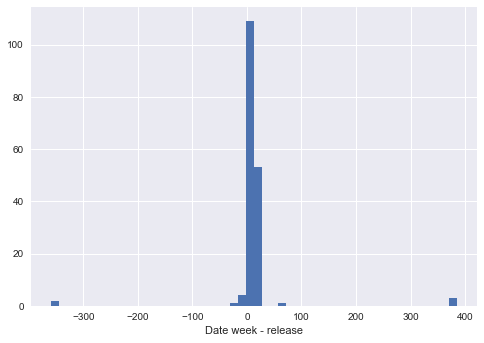

In [366]:
df = df.assign(release_week = (df.cdweek - df.release).dt.days)
ax = df.release_week.hist(bins = 50)
ax.set_xlabel('Date week - release')
plt.show()

In [367]:
df['week_deadline'] = pd.DatetimeIndex( df['release'] ) + pd.DateOffset(weeks = 5)

In [368]:
import datetime
today = datetime.datetime.now()
s = ((df.r_week == 1) & (today > df.week_deadline)) & ( (df.release_week <= 0) | (df.cdweek.isnull()) )

df.loc[s,['id', 'r_week', 'release', 'cdweek', 'release_week', 'week_deadline', 'release_week']].sort_values('id')

,id,r_week,release,cdweek,release_week,week_deadline,release_week
138,10272,1.0,2017-03-06,NaT,NaN,2017-04-10,NaN
150,10285,1.0,2017-03-17,NaT,NaN,2017-04-21,NaN
153,10288,1.0,2017-03-18,NaT,NaN,2017-04-22,NaN
180,20032,1.0,2016-10-16,2016-10-12,-4.0,2016-11-20,-4.0
193,20071,1.0,2016-10-18,2016-10-13,-5.0,2016-11-22,-5.0
194,20081,1.0,2016-10-19,NaT,NaN,2016-11-23,NaN
204,20142,1.0,2016-11-15,NaT,NaN,2016-12-20,NaN
222,20198,1.0,2016-12-28,2016-01-06,-357.0,2017-02-01,-357.0
209,20219,1.0,2017-01-13,2016-01-20,-359.0,2017-02-17,-359.0
105,20229,1.0,2017-01-18,2017-01-07,-11.0,2017-02-22,-11.0


In [369]:
tab  = df.loc[ (today > df.week_deadline) | (df.r_week == 1), 'r_week'].value_counts()
rr_week = [i / sum(list(tab)) for i in tab][0]
print(rr_week)

0.808035714286



# Two Months
 

In [370]:
varname = [col for col in df.columns if 'participa ' in col]
print(varname)

['participa ', 'participa .1', 'participa .2']


In [371]:
df = df.rename(columns={varname[0]: 'r_2months'})
df.r_2months.value_counts()
df['r_2months'] = df['r_2months'].str.contains("s|S").astype(float)
df['r_2months'] = df.r_2months.fillna(0)
df.r_2months.isnull().value_counts()
df.r_2months.value_counts()

1.0    175
0.0     50
Name: r_2months, dtype: int64

In [372]:
# date 2months
varname = [col for col in df.columns if 'fecha entrevista' in col]
print(varname)

['fecha entrevista.1', 'fecha entrevista.2', 'fecha entrevista.3']


In [373]:
df = df.rename(columns={varname[0]: 'd2months'})

In [374]:
df['cd2months'] = [clean_dates(i) for i in df['d2months']]

In [375]:
m = df.cd2months.isnull() & df.d2months.notnull()
df.loc[m, ['id', 'release', 'cd2months', 'd2months']]

,id,release,cd2months,d2months
83,50190,2016-12-18,NaT,27/2
111,30241,2017-01-26,NaT,13-0-2017


In [376]:
# replace errors in data entry
errors = ['27/2']
new_values = ['02/27/2017']

for i in range(0,len(errors)):
   df.loc[df['d2months'] == errors[i], 'cd2months'] = pd.to_datetime(new_values[i])


In [377]:
s = (df.r_2months == 1)
df.loc[s, 'cd2months'].isnull().value_counts()

False    166
True       9
Name: cd2months, dtype: int64

In [378]:
df = df.assign(release_2months = (df.cd2months - df.release).dt.days)
#df.release_2months.describe()

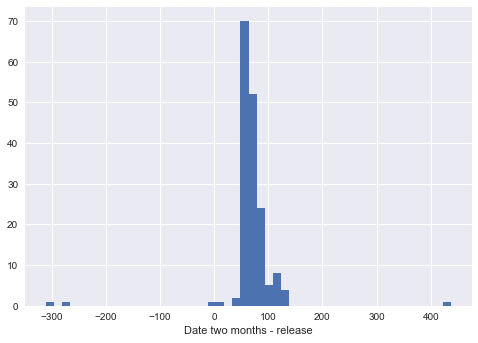

In [379]:
ax = df.release_2months.hist(bins = 50)
ax.set_xlabel('Date two months - release')
plt.show()

In [380]:
df['two_months_deadline'] = pd.DatetimeIndex( df['release'] ) + pd.DateOffset(months = 5)
s = ((df.r_2months == 1) & (today > df.two_months_deadline)) & ( (df.release_2months <= 0) | (df.cd2months.isnull()))
df.loc[s,['id', 'r_2months', 'release', 'cd2months', 'two_months_deadline', 'release_2months']].sort_values('id')

,id,r_2months,release,cd2months,two_months_deadline,release_2months
84,10099,1.0,2016-12-20,NaT,2017-05-20,NaN
81,10187,1.0,2016-12-16,NaT,2017-05-16,NaN
97,10213,1.0,2017-01-08,NaT,2017-06-08,NaN
106,10228,1.0,2017-01-18,NaT,2017-06-18,NaN
115,10244,1.0,2017-02-04,NaT,2017-07-04,NaN
194,20081,1.0,2016-10-19,NaT,2017-03-19,NaN
76,20095,1.0,2016-12-07,NaT,2017-05-07,NaN
222,20198,1.0,2016-12-28,2016-02-21,2017-05-28,-311.0
30,30092,1.0,2016-10-19,2016-01-13,2017-03-19,-280.0
73,30178,1.0,2016-12-06,NaT,2017-05-06,NaN


In [381]:
tab  = df.loc[ (today > df.two_months_deadline) | (df.r_2months == 1), 'r_2months'].value_counts()
print(tab)
rr_2months = [i / sum(list(tab)) for i in tab][0]
#print(rr_2months)

1.0    175
0.0     46
Name: r_2months, dtype: int64


## Six Months

In [382]:
varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [383]:
df = df.rename(columns={varname[0]: 'r_6months'})
df.r_6months.value_counts()
df['r_6months'] = df['r_6months'].str.contains("s|S").astype(float)
df['r_6months'] = df.r_6months.fillna(0)
#df.r_6months.isnull().value_counts()
#df.r_6months.value_counts()

In [384]:
# date 6months
varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [385]:
df = df.rename(columns={varname[0]: 'd6months'})
df['cd6months'] = [clean_dates(i) for i in df['d6months']]

m = df.cd6months.isnull() & df.d6months.notnull()
df.loc[m, ['id', 'release', 'cd6months', 'd6months']]

,id,release,cd6months,d6months
93,10182,2016-12-30,NaT,15-05-207
132,40267,2017-02-25,NaT,-
162,30001,2016-09-14,NaT,3017-04-24 00:00:00


In [386]:
s = (df.r_6months == 1)
#df.loc[s, 'cd6months'].isnull().value_counts()

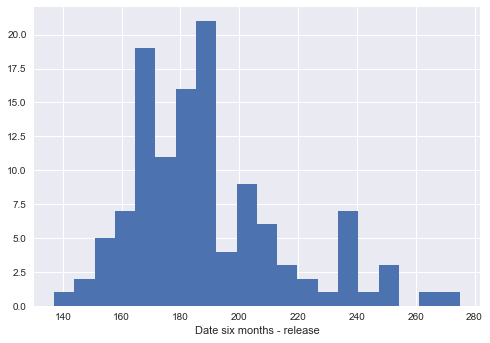

In [387]:
df = df.assign(release_6months = (df.cd6months - df.release).dt.days)

ax = df.release_6months.hist(bins = 20)
ax.set_xlabel('Date six months - release')
plt.show()

In [388]:
df['six_months_deadline'] = pd.DatetimeIndex( df['release'] ) + pd.DateOffset(months = 9)
s = ((df.r_6months == 1) & (today > df.six_months_deadline)) & ( (df.release_6months <= 0) | (df.cd6months.isnull()))
df.loc[s,['id', 'r_6months', 'release', 'd6months', 'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

,id,r_6months,release,d6months,cd6months,six_months_deadline,release_6months
166,10007,1.0,2016-09-20,NaN,NaT,2017-06-20,NaN
162,30001,1.0,2016-09-14,3017-04-24 00:00:00,NaT,2017-06-14,NaN


In [389]:
tab  = df.loc[(today > df.six_months_deadline)  | (df.r_6months == 1), 'r_6months'].value_counts()
print(tab)
rr_6months = [i / sum(list(tab)) for i in tab][0]
#print(rr_6months)

1.0    124
0.0     25
Name: r_6months, dtype: int64


# Plots of interview days by wave

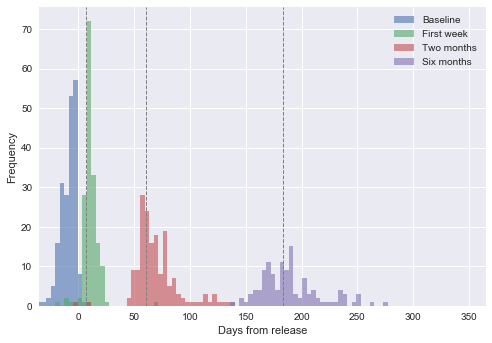

In [390]:
ax = df.loc[:, ['release_baseline', 'release_week', 'release_2months', 'release_6months']].plot.hist(alpha=0.6, bins = 200)
ax.set_xlim(-35,365)
ax.legend(['Baseline', 'First week', 'Two months', 'Six months'])
ax.axvline(7, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*2, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*6, color = 'gray', linestyle ='--', linewidth=1)
ax.set_xlabel('Days from release')
plt.show()

## Summary rates

In [391]:
rr = pd.DataFrame( {"rate" : [rr_week, rr_2months, rr_6months]}, 
                       index = ['week' ,'2 months', '6 months'])

rr

,rate
week,0.808036
2 months,0.791855
6 months,0.832215
